In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import matplotlib.pyplot as plt
import seaborn as sns   
from torchinfo import summary

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pwd

/workspace/localizing-edm


In [3]:
LOAD_EDM = False

In [4]:
import torch
import dnnlib
import pickle
import pandas as pd
import numpy as np


model_root = '/workspace/localizing-edm/workdir/pretrained_models'

if LOAD_EDM:
    model_file = f'{model_root}/edm-cifar10-32x32-uncond-ve.pkl' 
else:
    model_file = f'{model_root}/baseline-cifar10-32x32-uncond-ve.pkl' 
device = torch.device('cuda')
with dnnlib.util.open_url(model_file) as f:
    net = pickle.load(f)['ema'].to(device)

net

VEPrecond(
  (model): SongUNet(
    (map_noise): FourierEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
 

In [5]:
summary(net)

Layer (type:depth-idx)                   Param #
VEPrecond                                --
├─SongUNet: 1-1                          --
│    └─FourierEmbedding: 2-1             --
│    └─Linear: 2-2                       (131,584)
│    └─Linear: 2-3                       (262,656)
│    └─ModuleDict: 2-4                   --
│    │    └─Conv2d: 3-1                  (3,584)
│    │    └─UNetBlock: 3-2               (361,344)
│    │    └─UNetBlock: 3-3               (361,344)
│    │    └─UNetBlock: 3-4               (361,344)
│    │    └─UNetBlock: 3-5               (361,344)
│    │    └─UNetBlock: 3-6               (377,856)
│    │    └─Conv2d: 3-7                  (3,584)
│    │    └─UNetBlock: 3-8               (1,314,048)
│    │    └─UNetBlock: 3-9               (1,576,192)
│    │    └─UNetBlock: 3-10              (1,576,192)
│    │    └─UNetBlock: 3-11              (1,576,192)
│    │    └─UNetBlock: 3-12              (1,378,304)
│    │    └─Conv2d: 3-13                 (295,168)
│   

In [6]:
net.model.map_noise.freqs.shape

torch.Size([128])

In [7]:
x=torch.ones([1, net.img_channels, net.img_resolution, net.img_resolution], device=device)
t = torch.tensor([0.002], device=device)
x.shape

torch.Size([1, 3, 32, 32])

In [8]:
net = net.eval()
xhat = net(x,t)
xhat.shape

torch.Size([1, 3, 32, 32])

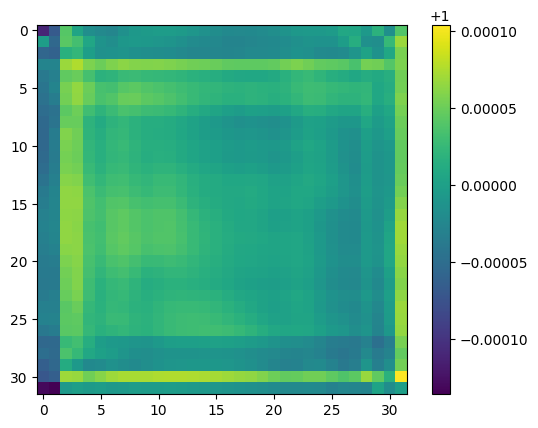

In [9]:
plt.imshow(xhat[0].permute(1,2,0).mean(-1).cpu())
plt.colorbar()

In [10]:
xhat.mean(), xhat.std()

(tensor(1.0000, device='cuda:0'), tensor(0.0002, device='cuda:0'))

In [11]:
num_steps=20
ve_sigma = lambda t: t.sqrt()
sigma_min = 0.002
sigma_max = 80
rho = 7

# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)

step_indices = torch.arange(num_steps, dtype=torch.float64, device="cpu")

orig_t_steps = (sigma_max ** 2) * ((sigma_min ** 2 / sigma_max ** 2) ** (step_indices / (num_steps - 1)))
sigma_steps = ve_sigma(orig_t_steps)

In [12]:
step_indices = torch.arange(num_steps, dtype=torch.float64, device="cpu")
edm_t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
edm_sigma_steps = net.round_sigma(edm_t_steps)


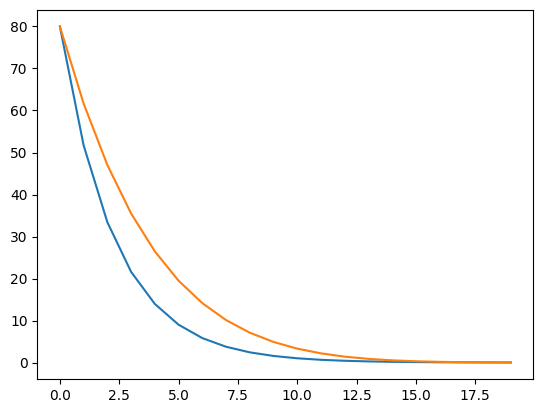

In [13]:
plt.plot(sigma_steps);
plt.plot(edm_sigma_steps);

<AxesSubplot: >

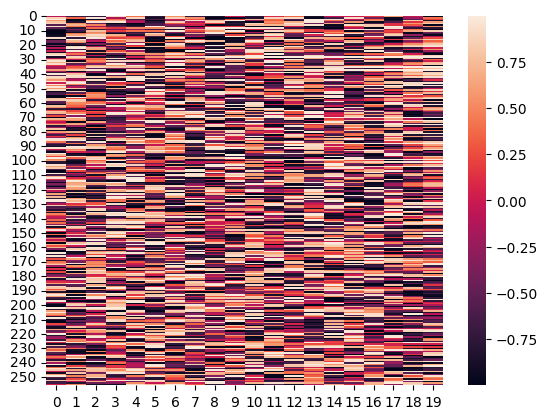

In [14]:
sns.heatmap(net.model.map_noise(sigma_steps.to(device)).T.cpu())

In [15]:
opts = dnnlib.EasyDict(
    data="workdir/datasets/cifar10-32x32.zip",
    xflip=False,
    augment=0.0,
    cond=False,
    cache=False,
    workers=1,
)

# Initialize config dict.
c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=opts.data,
    use_labels=opts.cond,
    xflip=opts.xflip,
    cache=opts.cache,
)
c.data_loader_kwargs = dnnlib.EasyDict(
    pin_memory=True, num_workers=opts.workers, prefetch_factor=1,
    batch_size=128
)

# Validate dataset options.
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs)
dataset_name = dataset_obj.name
c.dataset_kwargs.resolution = (
    dataset_obj.resolution
)  # be explicit about dataset resolution
c.dataset_kwargs.max_size = len(dataset_obj)  # be explicit about dataset size


In [16]:
from torch_utils import misc

seed = 42
dataset_obj = dnnlib.util.construct_class_by_name(
    **c.dataset_kwargs
)  # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(
    dataset=dataset_obj, rank=0, num_replicas=1, seed=seed
)
dataset_iterator = iter(
    torch.utils.data.DataLoader(
        dataset=dataset_obj, sampler=dataset_sampler, **c.data_loader_kwargs
    )
)

torch.Size([128, 3, 32, 32])

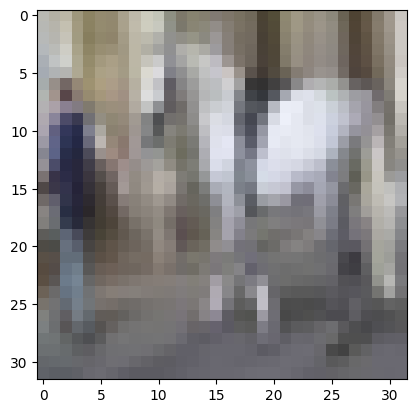

In [17]:
x_batch,_ = next(dataset_iterator)
x_batch = x_batch.to(device).to(torch.float32) / 127.5 - 1
plt.imshow((x_batch.permute(0,2,3,1)[0].cpu() + 1) / 2)
x_batch.shape

In [18]:
class OODGenerator:
    def __init__(self, iterator, patch_size=8):
        self.iterator = iterator
        self.psz = patch_size

    def __iter__(self):
        return self
    
    def __next__(self):
        x, y = next(self.iterator)
        
        # Modify the element as needed
        x = x.float()
        x[:, :, :self.psz, :self.psz] *= (1+torch.randn_like(x[:, :, :self.psz, :self.psz]))
        
        return x,y

ood_iterator = OODGenerator(dataset_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


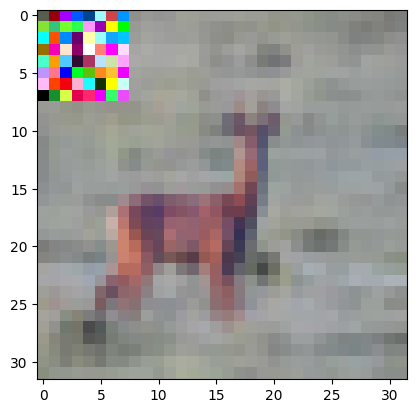

In [19]:
ood_batch,_ = next(ood_iterator)
ood_batch = ood_batch.to(device).to(torch.float32) / 127.5 - 1
plt.imshow((ood_batch.permute(0,2,3,1)[0].cpu() + 1) / 2)

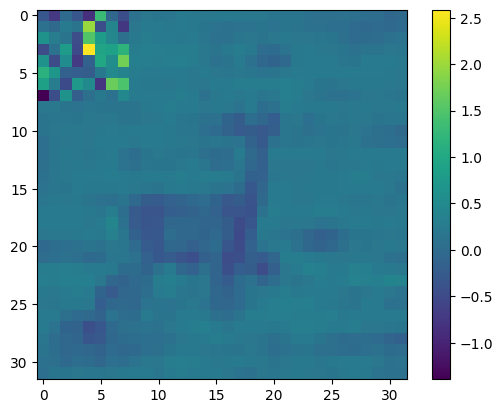

In [20]:
xhat = net(ood_batch, t)
plt.imshow(xhat[0].permute(1,2,0).mean(-1).cpu())
plt.colorbar()

In [21]:
from scorer import EDMScorer
from scorer import VEScorer

if LOAD_EDM:
    Scorer = EDMScorer
else:
    Scorer = VEScorer

score_fn = Scorer(
    net.model, sigma_min=net.sigma_min, sigma_max=net.sigma_max,
    # sigma_data=net.sigma_data, # for EDM cond
)


In [22]:
net.sigma_max, net.sigma_min

(100, 0.02)

In [23]:
score = score_fn(x_batch, torch.ones([1],device=device) * 80, debug=True)
score.shape

c_in: 1
c_noise: tensor([[[[3.6889]]]], device='cuda:0')
c_out: tensor([[[[80.]]]], device='cuda:0')


torch.Size([128, 3, 32, 32])

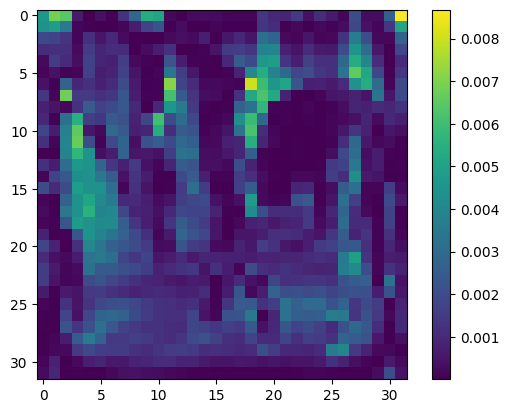

In [24]:
plt.imshow((score[0].permute(1,2,0).mean(-1).cpu())**2)
plt.colorbar()

In [25]:
from scorer import compute_scores

scores = compute_scores(
    net,
    dataset_iterator,
    sigma_max=80,
    sigma_min=0.02,
    model_type="edm" if LOAD_EDM else "ve",
)


In [26]:
score_norms = np.linalg.norm(
    scores.reshape(scores.shape[0], num_steps, -1), axis=-1
)


In [27]:
ood_scores = compute_scores(
    net,
    ood_iterator,
    sigma_max=80,
    sigma_min=0.02,
    model_type="edm" if LOAD_EDM else "ve",
)

ood_score_norms = np.linalg.norm(
    ood_scores.reshape(ood_scores.shape[0], num_steps, -1), axis=-1
)


In [28]:
recordify = lambda ds,name: [(i, sigma_steps[i].item(), x, name) for i, scores in enumerate(ds.T) for x in scores ]

records = [
    recordify(score_norms, "Train"),
    recordify(ood_score_norms, "OOD"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
df.shape

(5120, 4)

<AxesSubplot: xlabel='t', ylabel='score'>

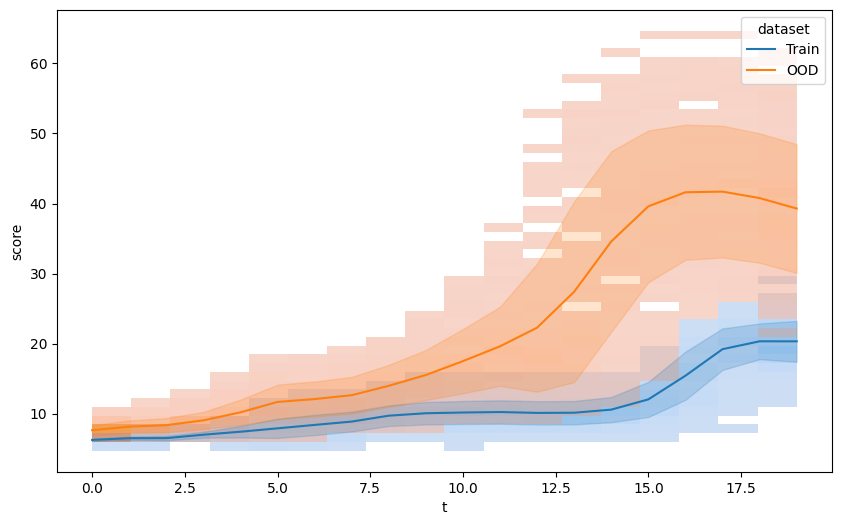

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.histplot(data=df, x="t", y="score", hue="dataset", ax=ax, alpha=0.6)
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar="sd", ax=ax)

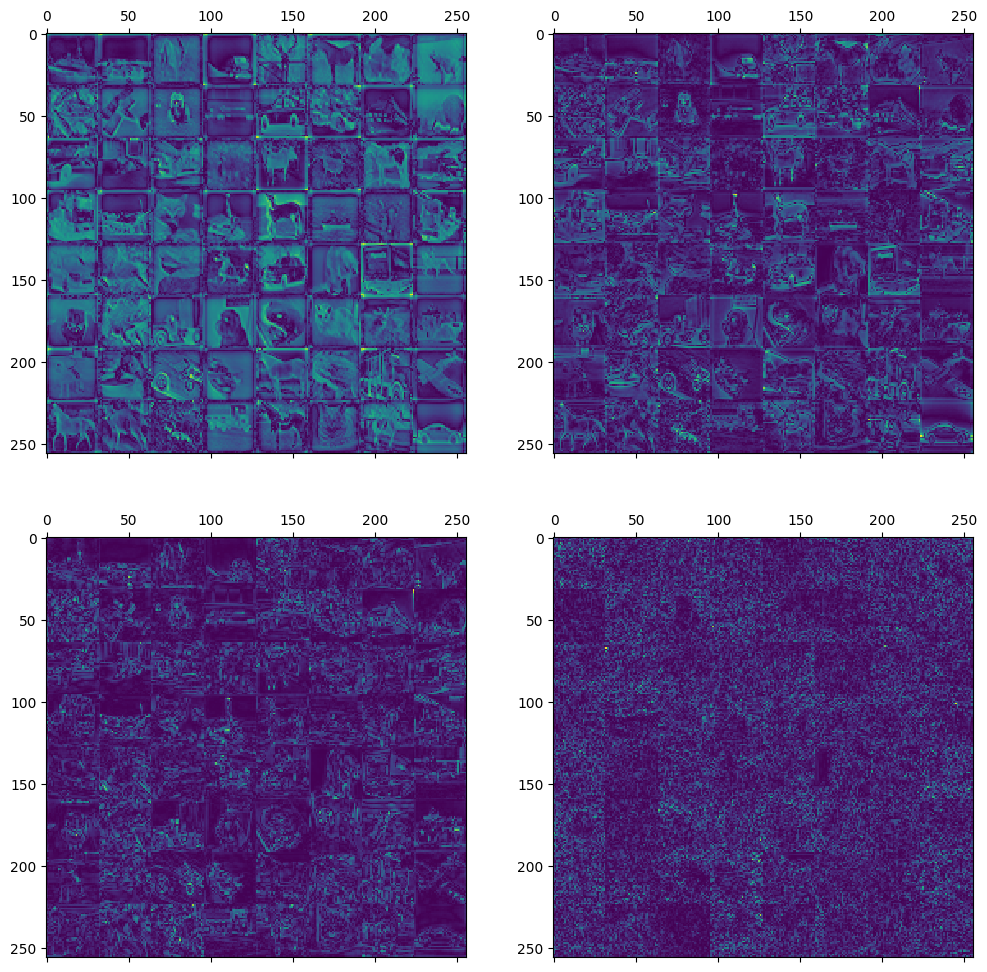

In [30]:
gridh=8
gridw=8

plot_idxs = [0, 5, 10, 19]

fig, axs = plt.subplots(2,2, figsize=(gridw*1.5, gridh*1.5))

for i, ax in zip(plot_idxs, axs.flatten()):

    image = np.abs(scores[:64, i].mean(1, keepdims=True))
    image = image.reshape(gridh, gridw, *image.shape[1:]).transpose(0, 3, 1, 4, 2)
    image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution,)
    
    ax.matshow(image)

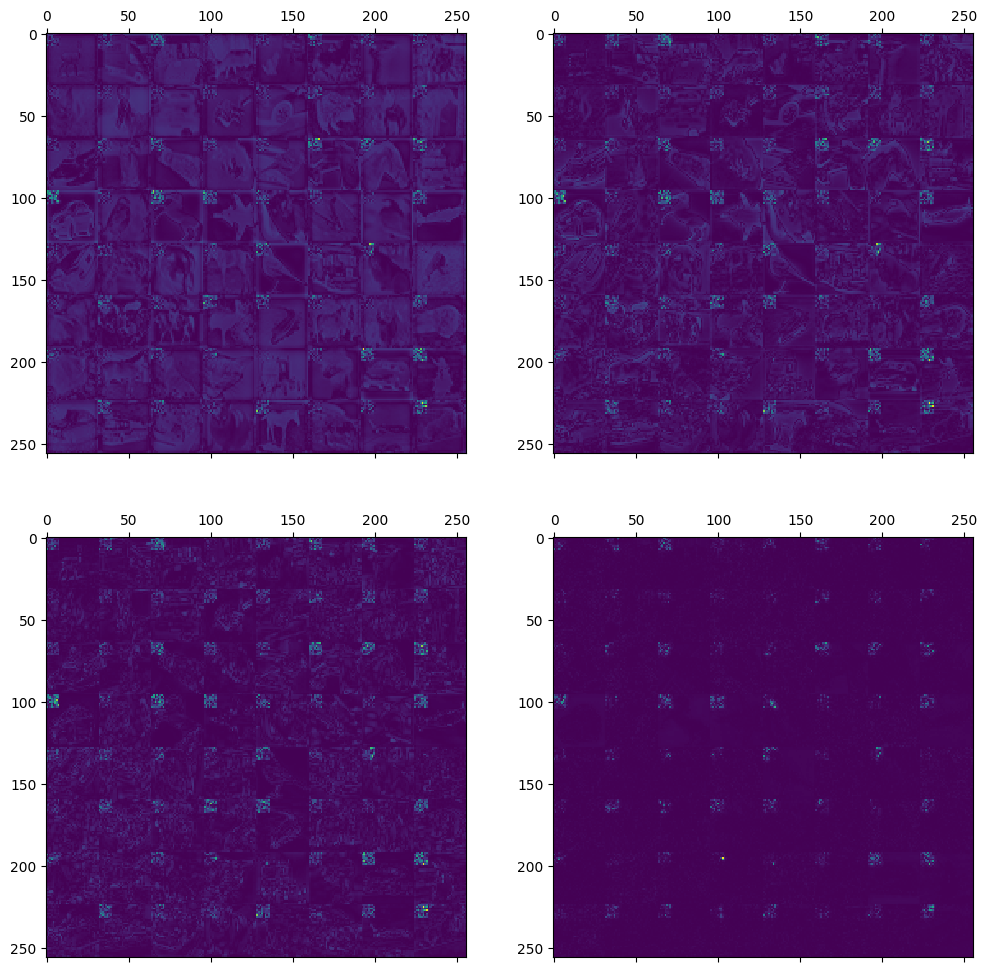

In [31]:
gridh=8
gridw=8

plot_idxs = [0, 5, 10, 19]

fig, axs = plt.subplots(2,2, figsize=(gridw*1.5, gridh*1.5))

for i, ax in zip(plot_idxs, axs.flatten()):

    image = np.abs(ood_scores[:64, i].mean(1, keepdims=True))
    image = image.reshape(gridh, gridw, *image.shape[1:]).transpose(0, 3, 1, 4, 2)
    image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution,)
    
    ax.matshow(image)

<AxesSubplot: >

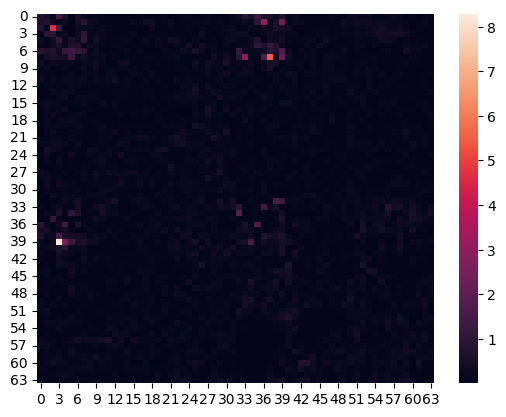

In [ ]:
sns.heatmap(image[:64,:64])

In [32]:
from ood_detection_helper import auxiliary_model_analysis

X_train = score_norms[:64]
X_test = score_norms[64:]
X_ood = [ood_score_norms]

m = auxiliary_model_analysis(
        X_train,
        X_test,
        X_ood,
        components_range=range(3, 6, 1),
        labels=["Train", "Inlier", "OOD"],
        kde=True,
        verbose=0
)

m["GMM"]["metrics"]

ap        de  fpr_tpr95  fpr_tpr99  pr_auc_in  pr_auc_out  \
OOD  99.696332  2.734375     1.5625      3.125   99.69518   98.745535   

       roc_auc  true_tpr95  
OOD  99.365234    92.96875

In [33]:
m["KD Tree"]["metrics"]

ap       de  fpr_tpr95  fpr_tpr99  pr_auc_in  pr_auc_out  \
OOD  99.950183  0.78125        0.0     1.5625  99.949982   99.825166   

       roc_auc  true_tpr95  
OOD  99.902344    92.96875

In [34]:
m["KDE"]["metrics"]

ap       de  fpr_tpr95  fpr_tpr99  pr_auc_in  pr_auc_out  \
OOD  99.956586  0.78125        0.0     1.5625  99.956413    99.84485   

       roc_auc  true_tpr95  
OOD  99.914551    92.96875

### Building a Flow Model

In [67]:
from tqdm.auto import tqdm
import torch.nn as nn
import FrEIA.framework as Ff
import FrEIA.modules as Fm

def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.GELU(),
                        nn.Linear(512,  c_out))

@torch.inference_mode()
def ll(inn, x):
    inn.eval()
    z, log_jac_det = inn(x)
    z = z.cpu().numpy()
    log_jac_det = log_jac_det.cpu().numpy()
    logpz = -0.5 * np.sum(z**2, axis=1) - log_jac_det
    return logpz, z

@torch.inference_mode()
def per_dim_ll(inn, x):
    inn.eval()
    z, log_jac_det = inn(x)
    z = z.cpu().numpy()
    log_jac_det = log_jac_det.cpu().numpy()
    logpz = -0.5 * z ** 2 - log_jac_det.reshape(-1, 1)
    return logpz, z

In [36]:
num_steps

20

In [37]:
inn = Ff.SequenceINN(num_steps)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

summary(inn)

Layer (type:depth-idx)                   Param #
SequenceINN                              --
├─ModuleList: 1-1                        --
│    └─AllInOneBlock: 2-1                840
│    │    └─Softplus: 3-1                --
│    │    └─Sequential: 3-2              15,892
│    └─AllInOneBlock: 2-2                840
│    │    └─Softplus: 3-3                --
│    │    └─Sequential: 3-4              15,892
│    └─AllInOneBlock: 2-3                840
│    │    └─Softplus: 3-5                --
│    │    └─Sequential: 3-6              15,892
│    └─AllInOneBlock: 2-4                840
│    │    └─Softplus: 3-7                --
│    │    └─Sequential: 3-8              15,892
│    └─AllInOneBlock: 2-5                840
│    │    └─Softplus: 3-9                --
│    │    └─Sequential: 3-10             15,892
│    └─AllInOneBlock: 2-6                840
│    │    └─Softplus: 3-11               --
│    │    └─Sequential: 3-12             15,892
│    └─AllInOneBlock: 2-7                

In [38]:
inn

SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=10, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=20, bias=True)
      )
    )
    (1): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=10, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=20, bias=True)
      )
    )
    (2): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=10, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=20, bias=True)
      )
    )
    (3): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(


In [39]:
# Setting up for training
inn = inn.cuda()
X_train = torch.tensor(score_norms[:64], dtype=torch.float32).cuda()
X_eval = torch.tensor(score_norms[64:], dtype=torch.float32).cuda()
X_ood = torch.tensor(ood_score_norms, dtype=torch.float32).cuda()
opt = torch.optim.Adam(inn.parameters(), lr=1e-3)

In [42]:
%%time
losses = []

for i in tqdm(range(100)):
    for xin in X_train.chunk(2):
        opt.zero_grad()
        z, log_jac_det = inn(xin)
        loss = torch.mean(z**2) - torch.mean(log_jac_det)
        loss.backward()
        opt.step()
    losses.append(loss.item())

100%|██████████| 100/100 [00:03<00:00, 28.48it/s]

CPU times: user 3.07 s, sys: 60.5 ms, total: 3.13 s
Wall time: 3.51 s


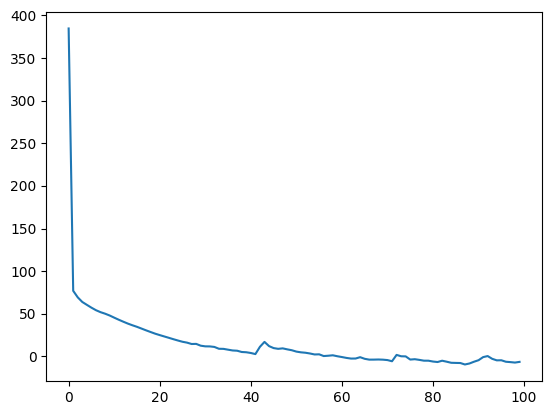

In [43]:
plt.plot(losses)

In [45]:
%%time
eval_lls, _ = ll(inn, X_eval)
ood_lls, _ = ll(inn, X_ood)

CPU times: user 0 ns, sys: 12.4 ms, total: 12.4 ms
Wall time: 32.6 ms


Inlier vs Outlier
----------------
ROC-AUC: 99.9878
PR-AUC (In/Out): 99.9939 / 99.9758
FPR (95% TPR): 0.00%
Detection Error: 0.39%
FPR (99% TPR): 0.00%


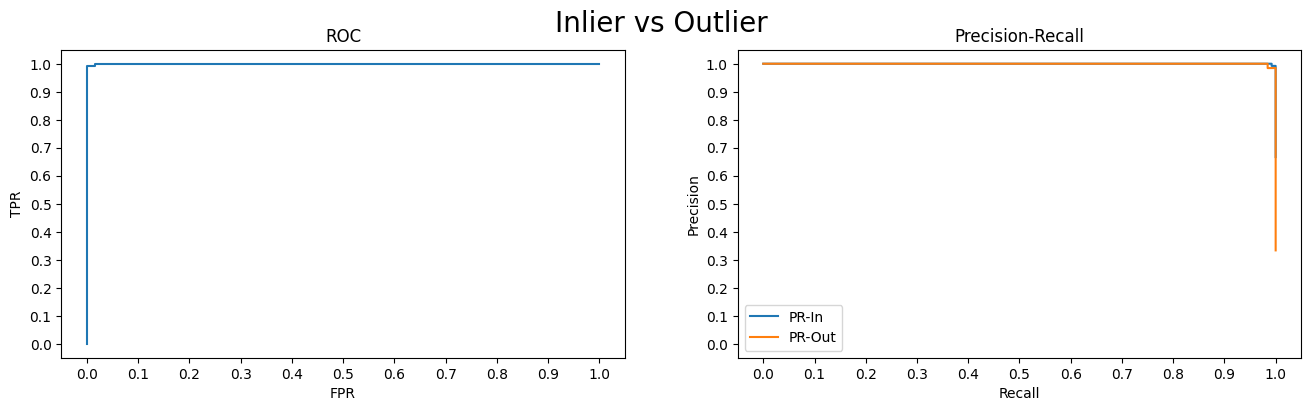

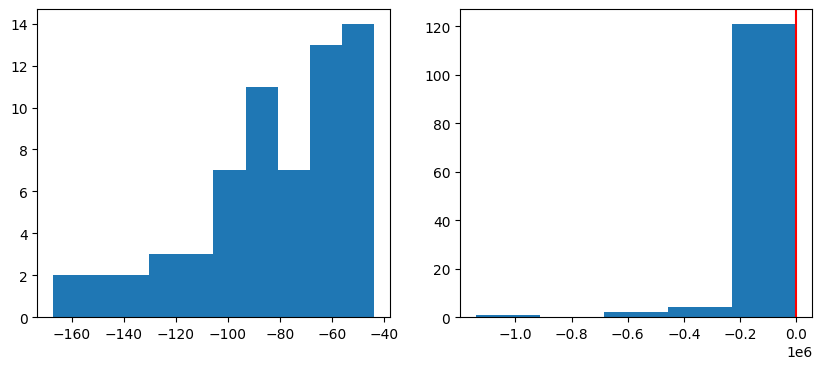

In [64]:
from ood_detection_helper import ood_metrics

ood_metrics(-eval_lls, -ood_lls, plot=True, verbose=True);

fig,axs = plt.subplots(1,2, figsize=(10,4))
axs[0].hist(eval_lls);
axs[1].hist(ood_lls, bins=5);
axs[1].axvline(eval_lls.min(), c="r");

In [68]:
%%time
eval_dim_lls, _ = per_dim_ll(inn, X_eval)
ood_dim_lls, _ = per_dim_ll(inn, X_ood)

CPU times: user 10.3 ms, sys: 19.9 ms, total: 30.2 ms
Wall time: 38.3 ms


In [78]:
eval_dim_df = pd.DataFrame(eval_dim_lls, columns=[f"s_{i}" for i in range(eval_dim_lls.shape[1])])
eval_dim_df.describe()

s_0        s_1        s_2        s_3        s_4        s_5  \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean  -14.571821 -16.213619 -18.514008 -15.084183 -16.696003 -16.229616   
std     3.301608   4.665934   5.212090   3.132856   5.113441   5.370460   
min   -21.254244 -29.281052 -41.556644 -20.932373 -43.583702 -37.810810   
25%   -16.418116 -17.575844 -20.919702 -16.574950 -18.864805 -18.321261   
50%   -15.303177 -15.424394 -17.353490 -15.312044 -16.281395 -15.401804   
75%   -13.614163 -13.898032 -15.253411 -14.147674 -14.143128 -14.160994   
max    -3.817608  -7.494932  -8.910860  -1.849207  -8.265930  -4.407266   

             s_6        s_7        s_8        s_9       s_10       s_11  \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean  -15.430113 -16.930124 -15.440914 -14.527561 -15.153254 -15.763046   
std     3.701684   6.269162   3.928292   3.866584   5.099381   4.628816   
min   -28.516958 -40.173889 -25.035427 -31.001108 -44.261566 -27.726603   
25%   -17.005927 -18.608728 -16.870495 -16.044840 -16.593055 -17.333589   
50%   -15.357473 -15.822192 -15.112658 -15.088360 -15.090190 -15.312937   
75%   -13.664231 -13.936713 -14.226549 -13.119559 -14.006322 -13.959244   
max    -6.459718  -1.955756  -2.880221  -1.675977  -1.400839  -2.325630   

            s_12       s_13       s_14       s_15       s_16       s_17  \
count  64.000000  64.000000  64.000000  64.000000  64.000000  64.000000   
mean  -16.626347 -20.159817 -19.948792 -16.852770 -16.071936 -15.715769   
std     4.740499   8.537947   8.327769   5.710050   4.275335   3.530443   
min   -27.963037 -57.586639 -58.951435 -43.344566 -32.266487 -25.826439   
25%   -18.479703 -23.848942 -22.354627 -17.980275 -16.862072 -16.880512   
50%   -16.479141 -18.346674 -17.516215 -16.116296 -15.295342 -15.463927   
75%   -14.517140 -15.687829 -15.376899 -14.251516 -14.307960 -14.195448   
max    -3.544713  -2.272354  -8.987428  -4.952641  -3.785049  -8.103162   

            s_18       s_19  
count  64.000000  64.000000  
mean  -17.032459 -18.612724  
std     5.077575   7.267311  
min   -29.901085 -42.599388  
25%   -19.678363 -20.453920  
50%   -15.957766 -16.754918  
75%   -13.657905 -14.838167  
max    -8.867964  -6.893408

In [82]:
ood_dim_df = pd.DataFrame(ood_dim_lls, columns=[f"s_{i}" for i in range(eval_dim_lls.shape[1])]).describe()
ood_dim_df.loc["mean"]

s_0    -2591.443359
s_1     -339.563843
s_2    -4471.674805
s_3    -1558.018188
s_4     -600.732788
s_5    -4918.697266
s_6    -1954.375732
s_7    -2769.356445
s_8    -2707.527344
s_9    -1627.028320
s_10   -1417.954102
s_11    -116.531494
s_12   -1928.148682
s_13   -7071.079590
s_14   -5843.363281
s_15   -1391.025146
s_16   -7291.489746
s_17   -1859.347168
s_18    -979.496643
s_19   -6255.565430
Name: mean, dtype: float64

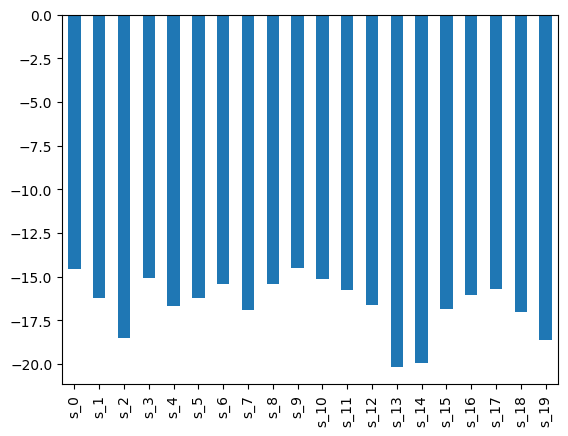

<AxesSubplot: >

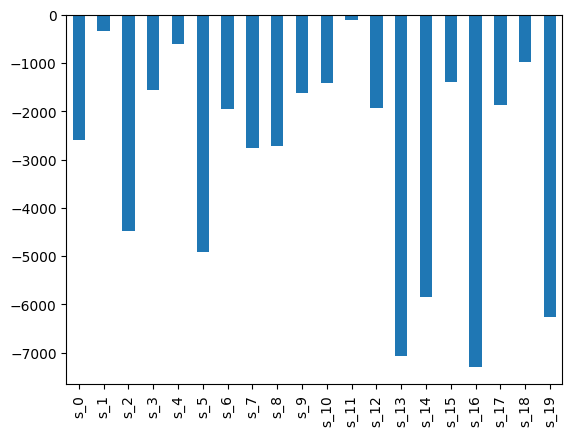

In [86]:
eval_dim_df.describe().loc["mean"].plot(kind="bar")
plt.show()
ood_dim_df.loc["mean"].plot(kind="bar")

In [84]:
recordify = lambda ds,name: [(i, sigma_steps[i].item(), x, name) for i, scores in enumerate(ds.T) for x in scores ]

records = [
    recordify(eval_dim_lls, "Inliers"),
    recordify(ood_dim_lls, "OOD"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
df.shape

(3840, 4)